This entire notebook is useful to note which problems I encountered in terms of preparing the .xml files for generating TFRecords (binary form data). However, the entire notebook was made when my dataset was faulty. I had neglected the option of annotating other objects in my images, so only houses were annotated in 'house' images, and trees in the background were left without bounding boxes. This lack of quality would confuse the model's accuracy.

After I had fixed a much smaller dataset of images, and made sure to label each object I wanted to detect, the model was much more accurate.

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=0c65657d9713a4d90c14a4a34183ba0067192e0879094056e873b4b089f2f306
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import os
import glob
import wget
import imghdr
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

The first model I would like to try is the 'SSD MobileNet V2 FPNLite 320x320' model, which offers a computing speed of 22 milliseconds per frame, and an average precision of 22.2 units.

(Precision and recall are two values used to measure the validity of the model. They will be explained below when I train these models.)

In [ ]:
CUSTOM_MODEL_NAME = 'topdown'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

The second model I would like to try offers a computing speed of 39 milliseconds per frame, and an average precision of 28.2 units. This model resizes the units to a larger size, 640 x 640. This model would enable the model to capture more features, so it would be worth testing out. However, overfitting could be an issue here, if a large model is asked to learn more features. Therefore, the training steps will be kept at around 10,000 - 12,500.

In [ ]:
CUSTOM_MODEL_NAME = 'thirdtry640x640'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
paths = {
    'WORKSPACE_PATH': os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('/content/drive/MyDrive/Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('/content/drive/MyDrive/Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH':os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH':os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH':os.path.join('/content/drive/MyDrive/Tensorflow','protoc')
 }

In [ ]:
files = {
    'PIPELINE_CONFIG':os.path.join('/content/drive/MyDrive/Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    os.makedirs(path, exist_ok=True)
    print(f"Created directory: {path}")

Created directory: /content/drive/MyDrive/Tensorflow/workspace
Created directory: /content/drive/MyDrive/Tensorflow/scripts
Created directory: /content/drive/MyDrive/Tensorflow/models
Created directory: /content/drive/MyDrive/Tensorflow/workspace/annotations
Created directory: /content/drive/MyDrive/Tensorflow/workspace/images
Created directory: /content/drive/MyDrive/Tensorflow/workspace/models
Created directory: /content/drive/MyDrive/Tensorflow/workspace/pre-trained-models
Created directory: /content/drive/MyDrive/Tensorflow/workspace/models/topdown
Created directory: /content/drive/MyDrive/Tensorflow/workspace/models/topdown/export
Created directory: /content/drive/MyDrive/Tensorflow/workspace/models/topdown/tfjsexport
Created directory: /content/drive/MyDrive/Tensorflow/workspace/models/topdown/tfliteexport
Created directory: /content/drive/MyDrive/Tensorflow/protoc


# Image Moving and Preparation

In [ ]:
folder_path = '/content/drive/MyDrive/Tensorflow/workspace/images/test/TREES_test'

In [ ]:
# List all files in the folder
file_list = os.listdir(folder_path)

Naming each filename according to its class:

In [ ]:
# Iterate through each file and rename with the prefix
for filename in file_list:
    if not filename.startswith('tree'):
        new_filename = 'tree_' + filename
        original_file_path = os.path.join(folder_path, filename)
        new_file_path = os.path.join(folder_path, new_filename)
        os.rename(original_file_path, new_file_path)
        #print(f'Renamed: {filename} -> {new_filename}')

I need to update the .xml files for each image now:

In [ ]:
base_dir = '/content/drive/MyDrive/Tensorflow/workspace/images'
subfolders = ['train', 'test']

In [ ]:
for subfolder in subfolders:
    subfolder_path = os.path.join(base_dir, subfolder)
    #for root, dirs, files in os.walk(subfolder_path):
    for xml_file in glob.glob(subfolder_path + '/*.xml'):
          tree = ET.parse(xml_file)
          root = tree.getroot()

          # Extract the filename from the XML file
          xml_filename = os.path.basename(xml_file).replace('.xml', '') + '.jpg'

          # Update the <filename> element
          filename_element = root.find('filename')
          if filename_element is not None:
            filename_element.text = xml_filename

          path_element = root.find('path')
          if path_element is not None:
            new_path = os.path.join(subfolder, xml_filename)
            path_element.text = new_path

          # Save the changes back to the XML file
          tree.write(xml_file)
          #print(f"Updated {xml_file}")

In [ ]:
for subfolder in subfolders:
    subfolder_path = os.path.join(base_dir, subfolder)
    for xml_file in glob.glob(subfolder_path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract the filename from the XML file
        xml_filename = os.path.basename(xml_file).replace('.xml', '')

        # Find the corresponding image file
        image_extensions = ['.jpg', '.jpeg', '.png', '.jfif']  # Add other possible extensions
        image_file = None
        for ext in image_extensions:
            image_path = os.path.join(subfolder_path, xml_filename + ext)
            if os.path.exists(image_path):
                image_file = xml_filename + ext
                break

        if image_file is not None:
            # Update the <filename> element
            filename_element = root.find('filename')
            if filename_element is not None:
                filename_element.text = image_file

            # Update the <path> element
            path_element = root.find('path')
            if path_element is not None:
                new_path = os.path.join(subfolder, image_file)
                path_element.text = new_path

            # Save the changes back to the XML file
            tree.write(xml_file)

Extracting the images into the 'train', and 'test' folders

In [ ]:
source_folder = '/content/drive/MyDrive/Tensorflow/workspace/images/train/TREES_train'
destination_folder = '/content/drive/MyDrive/Tensorflow/workspace/images/train'

In [ ]:
for filename in os.listdir(source_folder):
  source_path = os.path.join(source_folder, filename)
  destination_path = os.path.join(destination_folder, filename)

  # Move the file to the destination folder
  shutil.move(source_path, destination_path)

print("Files moved successfully!")

Files moved successfully!


# Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

only need to do this ONCE

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into '/content/drive/MyDrive/Tensorflow/models'...
remote: Enumerating objects: 87125, done.
remote: Counting objects: 100% (879/879), done.
remote: Compressing objects: 100% (403/403), done.
remote: Total 87125 (delta 522), reused 792 (delta 468), pack-reused 86246
Receiving objects: 100% (87125/87125), 599.11 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (62396/62396), done.
Updating files: 100% (3563/3563), done.


In [ ]:
!apt-get install protobuf-compiler
!cd /content/drive/MyDrive/Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Processing /content/drive/MyDrive/Tensorflow/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

Run the above code at the start of each runtime, then run the following cell to import all the necessary modules in the environment. Colab creates a new environment automatically, but actions in Command Prompt will need a new environment created for this task.

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2023-08-28 08:23:18.903537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 08:23:19.878388: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-28 08:23:22.849133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-28 08:23:23.395765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [ ]:
import object_detection

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.5.0
anyio                            3.7.1
apache-beam                      2.49.0
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.1
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
avro-python3                     1.10.2
Babel                            2.12.1
backcall                         0.2.0

This cell downloads the pre-trained model you named as PRETRAINED_MODEL_NAME where PRETRAINED_MODEL_URL is available to pick from the list at https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [ ]:
!wget {PRETRAINED_MODEL_URL}
!mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
#!cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/pipeline.config
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/saved_model.pb
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/variables/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/variables/variables.index


In [ ]:
PRETRAINED_MODEL_NAME = '/content/drive/MyDrive/Tensorflow/workspace/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'

In [ ]:
#!wget {PRETRAINED_MODEL_URL}
#!mv {PRETRAINED_MODEL_NAME} {paths['PRETRAINED_MODEL_PATH']}
!cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME}

./
./saved_model.pb
./variables/
./variables/variables.data-00000-of-00001
./variables/variables.index


# backup folder for object detection image set
<br> 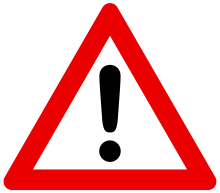
<br> <u>**Backups are so important to have!!!**</u>

In [ ]:
import shutil

source_folder = '/content/drive/MyDrive/Tensorflow/workspace/images/train2_converted'
backup_folder = '/content/drive/MyDrive/Tensorflow/workspace/images/train3_converted'

# Create a backup of the source folder
shutil.copytree(source_folder, backup_folder)

'/content/drive/MyDrive/Tensorflow/workspace/images/train3_converted'

# CREATE LABEL MAP

In [ ]:
import xml.etree.ElementTree as ET
from collections import Counter

The following functions are made to check the .xml files are all present for each image.

In [ ]:
def extract_labels(xml_file_path):
  labels = []

  tree = ET.parse(xml_file_path)
  root = tree.getroot()

  for obj in root.findall('object'):
    name = obj.find('name')
    if name is not None:
      labels.append(name.text)

  return labels

In [ ]:
def get_unique_labels(folder_path):
  all_labels = []

  for xml_filename in os.listdir(folder_path):
    if xml_filename.endswith('.xml'):
      xml_path = os.path.join(folder_path, xml_filename)
      labels = extract_labels(xml_path)
      all_labels.extend(labels)

  unique_labels = list(set(all_labels))
  return unique_labels

In [ ]:
folder_path = '/content/drive/MyDrive/OBJ_DETECTION_IMGS/TREES_OBJDET/test'
unique_labels = get_unique_labels(folder_path)

In [ ]:
print("Unique labels found in the XML files:")
for label in unique_labels:
  print(label)

Unique labels found in the XML files:
tree


In [ ]:
xml_dir = "/content/drive/MyDrive/Tensorflow/workspace/images/TOPDOWNtrain"
labels = set()

# Loop through XML files in the directory
for xml_file in os.listdir(xml_dir):
  if xml_file.endswith('.xml'):
    xml_path = os.path.join(xml_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall('object'):
      label = obj.find('name').text
      labels.add(label)

label_list = list(labels)
print("Labels found in XML files:")
print(label_list)

Labels found in XML files:
['car', 'sheep', 'person', 'vegetation', 'rock', 'house', 'water']


In [ ]:
#labels = [{'name':'birds', 'id':1}, {'name':'car', 'id':2}, {'name':'cliff', 'id':3}, {'name':'cloud', 'id':4}, {'name':'hay-bale', 'id':5}, {'name':'House', 'id':6}, {'name':'Lake', 'id':7}, {'name':'human', 'id':8}, {'name':'tree', 'id':9}]

with open(files['LABELMAP'], 'w') as f:
  for label in labels:
    f.write('item { \n')
    f.write('\tname:\'{}\'\n'.format(label['name']))
    f.write('\tid:{}\n'.format(label['id']))
    f.write('}\n')

In [ ]:
labels = [{'name':'car', 'id':1}, {'name':'house', 'id':2}, {'name':'person', 'id':3}, {'name':'rock', 'id':4}, {'name':'sheep', 'id':5}, {'name':'vegetation', 'id':6}, {'name':'water', 'id':7}]
#with open(files['LABELMAP'], 'w') as f:
#  for label in labels:
#     f.write('item { \n')
#     f.write('\tname:\'{}\'\n'.format(label['name']))
#     f.write('\tid:{}\n'.format(label['id']))
#     f.write('}\n')

In [ ]:
image_folder = ['/content/drive/MyDrive/Tensorflow/workspace/images/TOPDOWNtest']

In [ ]:
for folder in image_folder:
  for root, dirs, files in os.walk(folder):
    for file in files:
      if file.lower().endswith(('.jpg', '.png', '.jfif', '.jpeg')):
        image_path = os.path.join(root, file)
        try:
          img = Image.open(image_path)
        except Exception as e:
          print(f"Error processing image: {image_path}")
          print(f"Error message: {str(e)}")

In [ ]:
for folder in image_folder:
  for root, dirs, files in os.walk(folder):
    for file in files:
      if not file.lower().endswith('.xml'):
        image_path = os.path.join(root, file)
        try:
          # Use TensorFlow to load the image
          img_raw = tf.io.read_file(image_path)
          img = tf.image.decode_image(img_raw)

        except Exception as e:
          print(f"Error processing image: {image_path}")
          print(f"Error message: {str(e)}")

Error processing image: /content/drive/MyDrive/Tensorflow/workspace/images/train_small/Lake_lake3.jpg
Error message: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage]
Error processing image: /content/drive/MyDrive/Tensorflow/workspace/images/train_small/Lake_lake115.jpg
Error message: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage]
Error processing image: /content/drive/MyDrive/Tensorflow/workspace/images/train_small/Lake_lake67.jpg
Error message: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage]
Error processing image: /content/drive/MyDrive/Tensorflow/workspace/images/train_small/Lake_lake136.jpg
Error message: {{fun

Some images cannot be processed by the Tensorflow image processing module. This seems to be a common problem when using images collected from Google. They are all .jpg files so the error doesn't really help:
```
<br>Error processing image: /content/drive/MyDrive/Tensorflow/workspace/images/train_small/Lake_lake3.jpg
Error message: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name:

```
It could be worth analysing the images to see if some outlying pixel values are causing the issue.

